# NDWI calculation from Landsat
## Created by: Gert Sterenborg
## 20 January 2016


This script is created to extract to generate a tif file with the ndwi values. It is calculated with the use of band 4 and 5 of a landsat image.


In [1]:
## import modules
import os
import glob
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly, GDT_Float32
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


datafolder = './data/LC81980242014260-SC20150123044700/'

def listTifFiles(datafolder):
    return glob.glob(datafolder+"*.tif")
    
allTifs = listTifFiles(datafolder)

print ("available bands are:")
for tif in sorted(allTifs):
    print tif[-9:-4]+" ",

available bands are:
fmask  band1  band2  band3  band4  band5  band6  band7  cloud 


In [2]:
# show some basic information about band 4

def findTif(tifs,bandName):
    for tif in tifs:
        if tif[-9:-4] == bandName:
            return tif

band4 = findTif(allTifs,"band4")
band5 = findTif(allTifs,"band5")

dataSource4 = gdal.Open(band4, GA_ReadOnly)
dataSource5 = gdal.Open(band5, GA_ReadOnly)

print "\nInformation about band 4"
print "Driver: ", dataSource4.GetDriver().ShortName,"/", \
      dataSource4.GetDriver().LongName
print "Size is ",dataSource4.RasterXSize,"x",dataSource4.RasterYSize, \
      'x',dataSource4.RasterCount

print '\nProjection is: ', dataSource4.GetProjection()

print "\nInformation about the location of the image and the pixel size:"
geotransform = dataSource4.GetGeoTransform()
if not geotransform is None:
    print 'Origin = (',geotransform[0], ',',geotransform[3],')'
    print 'Pixel Size = (',geotransform[1], ',',geotransform[5],')'


Information about band 4
Driver:  GTiff / GeoTIFF
Size is  7791 x 7911 x 1

Projection is:  PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","32631"]]

Information about the location of the image and the pixel size:
Origin = ( 529185.0 , 5847015.0 )
Pixel Size = ( 30.0 , -30.0 )


In [3]:
# Read data into an array
band4Arr = dataSource4.ReadAsArray(0,0,dataSource4.RasterXSize, dataSource4.RasterYSize)
band5Arr = dataSource5.ReadAsArray(0,0,dataSource5.RasterXSize, dataSource5.RasterYSize)
print type(band4Arr)
                                                   

# set the data type
band4Arr=band4Arr.astype(np.float32)
band5Arr=band5Arr.astype(np.float32)

# Derive the NDWI
mask = np.greater(band5Arr+band4Arr,0)

# set np.errstate to avoid warning of invalid values (i.e. NaN values) in the divide 
with np.errstate(invalid='ignore'):
    ndwi = np.choose(mask,(-99,(band4Arr-band5Arr)/(band4Arr+band5Arr)))
print "NDVI min and max values", ndwi.min(), ndwi.max()
# Check the real minimum value
print ndwi[ndwi>-99].min()

<type 'numpy.ndarray'>
NDVI min and max values -99.0 21.3333
-2.36481


/home/ubuntu/.local/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in divide


In [4]:
# Write the result to disk
driver = gdal.GetDriverByName('GTiff')
outputName = './data/ndwi.tif'
outDataSet=driver.Create(outputName, dataSource4.RasterXSize, dataSource4.RasterYSize, 1, GDT_Float32)
outBand = outDataSet.GetRasterBand(1)
outBand.WriteArray(ndwi,0,0)
outBand.SetNoDataValue(-99)

# set the projection and extent information of the dataset
outDataSet.SetProjection(dataSource4.GetProjection())
outDataSet.SetGeoTransform(dataSource4.GetGeoTransform())

# Finally let's save it... or like in the OGR example flush it
outBand.FlushCache()
outDataSet.FlushCache()

if outputName in listTifFiles("./data/"):
    print outputName + " file is created!"
else:
    print "something went wrong"

./data/ndwi.tif file is created!


In [5]:
wgs84Name = "./data/ndviWGS84.tif"
os.system("gdalwarp -t_srs \"EPSG:4326\" \
        "+outputName+" \
        "+wgs84Name)
if wgs84Name in listTifFiles("./data/"):
    print wgs84Name + " file is created!"
else:
    print "something went wrong"

./data/ndviWGS84.tif file is created!


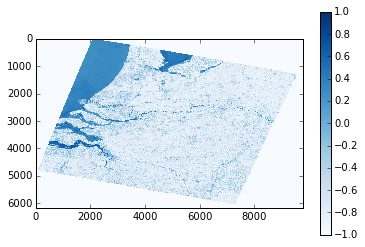

In [6]:
# Open image to plot
dsll = gdal.Open(wgs84Name)

# Read raster data
ndwi = dsll.ReadAsArray(0, 0, dsll.RasterXSize, dsll.RasterYSize)

# Now plot the raster data using gist_earth palette
plt.imshow(ndwi, interpolation='bilinear', vmin=-1, vmax=1, cmap=plt.cm.gist_earth, clim=(-1.0, 1.0))
plt.set_cmap('Blues')
plt.colorbar()
plt.show()

dsll = None